In [137]:
import os as os
import sys as sys
import time as time

import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm
import theano
import theano.tensor as tt

import pandas as pd

In [138]:
RANDOM_SEED = 123446
np.random.seed(RANDOM_SEED)

# Restrict BLAS to operate on a single thread at a time,
# since multithreading doesn't play well with multiple parallel chains
os.environ["OPENBLAS_NUM_THREADS"] = "1"

# Checking versions
print("Theano version: {}".format(theano.__version__))
print("PyMC3 version: {}".format(pm.__version__))

Theano version: 1.0.5
PyMC3 version: 3.8


In [139]:
class BodyFat(tt.Op):
    
    
    # Specify what type of object will be passed and returned to the Op when it is
    # called. In our case we will be passing it a vector of values (the parameters
    # that define our model and a model object) and returning a single "scalar"
    # value (the log-likelihood)
    itypes = [tt.dvector]  # expects a vector of parameter values when called
    otypes = [tt.dscalar]  # outputs a single scalar value (the log likelihood)
    
    def __init__(self, level = -1):
        
        self.level = level
        
        df = pd.read_csv('data/bodyfat.csv')

        fullData = df[["Bodyfat","Abdomen"]].to_numpy()

        self.Data = []

        self.Data.append(fullData[0:50,:])
        self.Data.append(fullData)
        
    def plotData(self, samples = np.array([]), saveFig = False, fileName = 'Data.pdf'):
          
        _, ax = plt.subplots(figsize=(5, 4))
        ax.plot(Data[1][:,1],Data[1][:,0], "o", alpha = 0.2, label="Full Data")
        ax.plot(Data[0][:,1],Data[0][:,0], "o", alpha = 0.5, label="Reduced Data")
        for i in range(samples.shape[0]):
            x_eval = np.linspace(60., 150.0, 2)
            y_eval = samples[i,0] + samples[i,1] * x_eval
            ax.plot(x_eval,y_eval, alpha = 1, label = "Posterior Samples")
            
        ax.set_ylabel("Body Fat (%)")
        ax.set_xlabel("Abdomen Circumference (cm)")
        ax.set_xticks([60., 80, 100., 120., 140., 160.])
        ax.legend();
        
        plt.savefig(fileName) 
        
        
    def perform(self, node, inputs, outputs):
        
        # the method that is used when calling the Op
        
        X, = inputs  # this will contain my variables

        # call the log-likelihood function
        logl = -np.sum((X[0] + X[1]*self.Data[self.level][:,0] - self.Data[self.level][:,1])**2)/(2 * X[2]**2)

        Q = X[0] + X[1] * 17.0 # Estimate 'Fit Upper Bound' for men
        
        outputs[0][0] = np.array(logl)  # output the log-likelihood
        

        
        



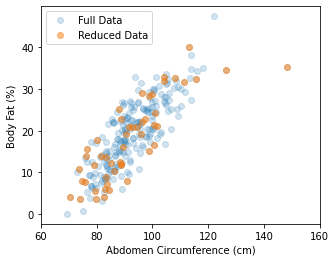

In [140]:
logLik = BodyFat()

# prior samples = np.array([-42., 0.65, 0.2]]), 

logLik.plotData(saveFig = True)

In [145]:
# Number of draws from the distribution
ndraws = 20000

# Number of burn-in samples
nburn = 2000

# MLDA and Metropolis tuning parameters
tune = True
tune_interval = 100  # Set high to prevent tuning.
discard_tuning = True
scaling = 0.01

# Number of independent chains.
nchains = 3

# Subsampling rate for MLDA
nsub = 5

# Do blocked/compounds sampling in Metropolis and MLDA
# Note: This choice applies only to the coarsest level in MLDA
# (where a Metropolis sampler is used), all other levels use block sampling
blocked = False

# Set prior parameters for multivariate Gaussian prior distribution.
mu_prior = np.zeros(2)

mu_prior[0] = -40.0
mu_prior[1] = 0.65
x = np.std(mu_prior[0]  + mu_prior[1]*logLik.Data[1][:,1] - logLik.Data[1][:,0])

k_prior = 5.0

cov_prior = np.eye(2)

cov_prior[0,0] = 5.0
cov_prior[1,1] = 0.2
theta_prior = 1.0

# Sampling seed
sampling_seed = RANDOM_SEED

In [147]:
# Define Coarse and Fine Models
all_models = []
for i in range(2):
    all_models.append(BodyFat(level = i))

coarse_models = []
for j in range(len(all_models) - 1):
    
    with pm.Model() as model:
        
        # uniform priors on m and c
        beta0 = pm.Normal('beta0', mu = -42.0, sigma=5.)
        beta1 = pm.Normal('beta1', mu = 0.65, sigma=0.1)
        sig = pm.InverseGamma('sig', mu = 4.86, sigma=np.sqrt(2))

        # convert m and c to a tensor vector
        theta = tt.as_tensor_variable([beta0, beta1, sig])

        # use a DensityDist (use a lamdba function to "call" the Op)
        pm.DensityDist('likelihood', lambda v: all_models[j](v), observed={'v': theta})
            
    coarse_models.append(model)
    

In [148]:
print(coarse_models)

In [149]:
# Set up finest model and perform inference with PyMC3, using the MLDA algorithm
# and passing the coarse_models list created above.
method_names = []
traces = []
runtimes = []

with pm.Model() as model:

    # uniform priors on m and c
    beta0 = pm.Normal('beta0', mu = -42.0, sigma=5.)
    beta1 = pm.Normal('beta1', mu = 0.65, sigma=0.1)
    sig = pm.InverseGamma('sig', mu = 4.86, sigma=np.sqrt(2))

    # convert m and c to a tensor vector
    theta = tt.as_tensor_variable([beta0, beta1, sig])

    # use a DensityDist (use a lamdba function to "call" the Op)
    pm.DensityDist('likelihood', lambda v: all_models[-1](v), observed={'v': theta})

    # Initialise a Metropolis, DEMetropolisZ and MLDA step method objects (passing the subsampling rate and
    # coarse models list for the latter)

    step_mlda = pm.MLDA(
        coarse_models=coarse_models,
        subsampling_rates=nsub,
        tune=tune,
        base_tune_interval=tune_interval,
        base_blocked=blocked,
        base_scaling=scaling,
    )

    # MLDA
    t_start = time.time()
    method_names.append("MLDA")
    traces.append(
        pm.sample(
            draws=ndraws,
            step=step_mlda,
            chains=nchains,
            tune=nburn,
            discard_tuned_samples=discard_tuning,
            random_seed=sampling_seed,
        )
    )
    runtimes.append(time.time() - t_start)

/Users/td336/miniconda3/envs/pymc3_env/lib/python3.8/site-packages/pymc3-3.8-py3.8.egg/pymc3/step_methods/metropolis.py:994: UserWarning: The MLDA implementation in PyMC3 is very young. You should be extra critical about its results.
  warnings.warn(
Multiprocess sampling (3 chains in 4 jobs)
MLDA: [sig, beta1, beta0]
Could not pickle model, sampling singlethreaded.
Sequential sampling (3 chains in 1 job)
MLDA: [sig, beta1, beta0]


The number of effective samples is smaller than 10% for some parameters.


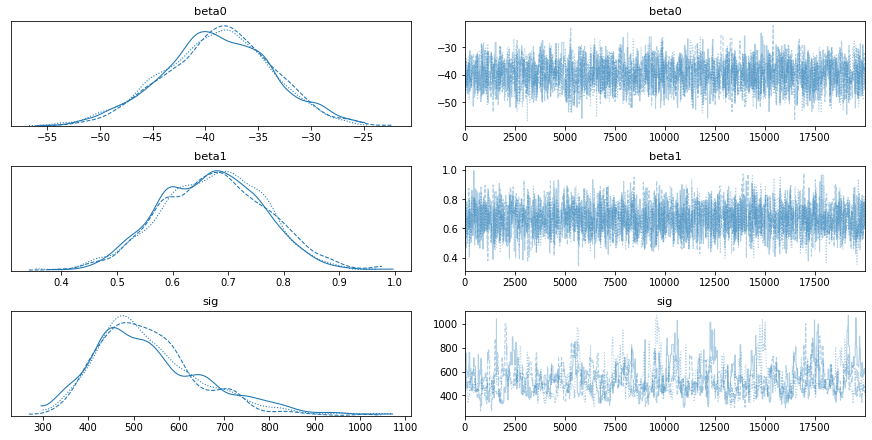

In [151]:
with model:
    pm.plots.traceplot(traces[0])